**(c)** 2023 by *Sebastian Bader*

[Mobile Multimedia Information Systems](https://www.mmis.informatik.uni-rostock.de/), 
[Institute for Visual and Analytic Computing](https://vac.uni-rostock.de/)

# Tutorial 16 - Classifiers based on pre-trained Autoencoders

A Jupyter Notebook as part of the lecture<br/>
***AI3 - Introduction to artificial neural networks***

---
Recommendet usage:

Please go through each of the greyish cells in this notebook (the one prefixed with `In [ ]`) step by step. Execute it by selecting the cell and pressing the `▶︎ Run`-button above, or pressing `SHIFT+ENTER`.
Within the notebook you will find some small tasks, marked as <font color=red>**[TASK]**</font>. 
Please complete them (usually in the cell directly below) before continuing the tutorial!

In [1]:
# TensorFlow and tf.keras
from tensorflow import keras
from keras.layers import Input, Dense, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, UpSampling2D
from keras.models import Model, clone_model

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Markdown,display

from sklearn.model_selection import train_test_split


Next we define a method to load a dataset, which contains two parts:

- training data
- test data

The training data is further split into a set of unlabelled data and a set of labelled data.
Please note, that the labels of the unlabelled data are also loaded and returned by the function, but they will never be used as target labels, but only be used to create visualisations.

I.e., finally we have three datasets:

- unlabelled training data
- labelled training data
- labelled test data


In [2]:
def load_preprocess_and_split_dataset(labeled_ratio=0.05, random_state=None):
    # dataset = keras.datasets.cifar10
    dataset = keras.datasets.mnist
    # dataset = keras.datasets.fashion_mnist
    
    train_all, test = dataset.load_data()
    
    (train_all_images, train_all_labels) = train_all
    
    X_train_unlabeled, X_train, y_train_unlabeled, y_train = train_test_split(
        train_all_images, train_all_labels, 
        test_size=labeled_ratio, 
        random_state=random_state, shuffle=True, 
        stratify=train_all_labels)
    
    (X_test, y_test) = test

    X_train_unlabeled = X_train_unlabeled / 255.0
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    # if the input is just 2-dimensional, it is a grey-scale image.
    # In order to make the convolutional layers below work correctly, 
    # we add a third dimension.
    # Please note, this does not change the data, but just it's structure.

    if len(X_train.shape) == 3:
        X_train_unlabeled = np.reshape(X_train_unlabeled, X_train_unlabeled.shape + (1,))
        X_train = np.reshape(X_train, X_train.shape + (1,))
        X_test = np.reshape(X_test, X_test.shape + (1,))
    
    input_shape = X_train.shape[1:]
    
    return input_shape, (X_train_unlabeled,y_train_unlabeled), (X_train, y_train), (X_test, y_test)


Let's load the data, and run sum checks

In [3]:
input_shape, (X_u,y_u), (X_l,y_l), (X_t,y_t) = load_preprocess_and_split_dataset()

# assert that all three datasets have common shape
assert X_u.shape[1:] == X_l.shape[1:] == X_t.shape[1:]

print('The data has an input dimension of %s' % (input_shape,))


# Let's make sure the output classes are identical for all three datasets
classes = list(np.unique(y_u))
classes_l = list(np.unique(y_l))
classes_t = list(np.unique(y_t))

assert classes == classes_l == classes_t

min_class = min(classes)
max_class = max(classes)

num_classes = len(classes)
print('The data contains the following %i classes: %s' % (num_classes, classes))



The data has an input dimension of (28, 28, 1)
The data contains the following 10 classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [4]:
# a little helper to plot a number of sample images

def showImages(n, labels, Images, random=True):
    plt.figure(figsize=(n*2, 2))
    iids = range(n)
    if random:
        iids = np.random.choice(iids, n, replace=False)
    for i,iid in enumerate(iids):
        plt.subplot(1, n, i+1)

        plt.title('IID=%i, GT=%s' % (iid, labels[iid]))
            
        # show the image and hide axis-ticks
        plt.imshow(Images[iid], cmap=plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
    plt.show()

def show_data(name, X, y=None, n=10):
    display(Markdown('The dataset **"%s"** has shape %s, i.e., %i elements of shape %s' % (name, X.shape, X.shape[0], X.shape[1:])))
    if y is not None:
        display(Markdown('The labels in **"%s"** have the following distribution:' % (name)))
        plt.figure(figsize=(2,2))
        plt.hist(y, bins=num_classes, range=(min_class-0.5, max_class+0.5), rwidth=0.9)
        plt.xticks(classes)
        plt.show()
    display(Markdown('The following line contains %i sampels of **"%s"**:' % (n, name)))
    showImages(n, y, X)

The dataset **"unlabelled"** has shape (57000, 28, 28, 1), i.e., 57000 elements of shape (28, 28, 1)

The labels in **"unlabelled"** have the following distribution:

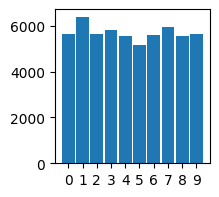

The following line contains 10 sampels of **"unlabelled"**:

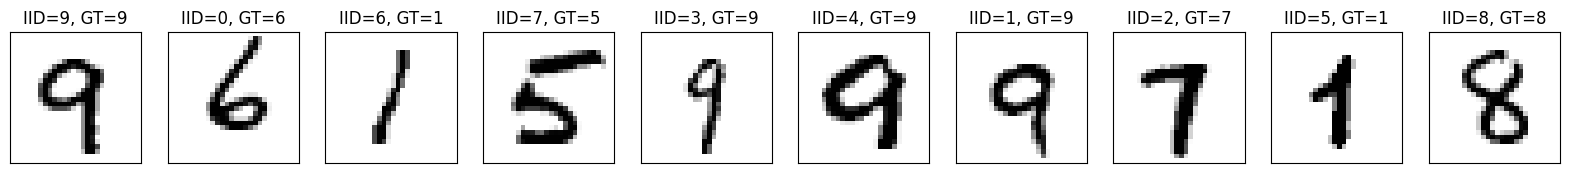

In [5]:
show_data('unlabelled', X_u, y_u)

The dataset **"labelled"** has shape (3000, 28, 28, 1), i.e., 3000 elements of shape (28, 28, 1)

The labels in **"labelled"** have the following distribution:

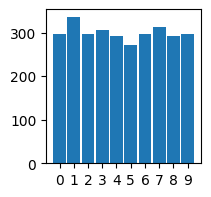

The following line contains 10 sampels of **"labelled"**:

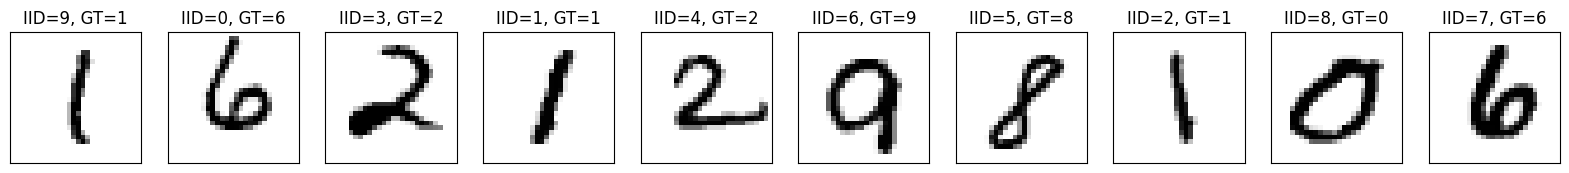

In [6]:
show_data('labelled', X_l, y_l)

The dataset **"test"** has shape (10000, 28, 28, 1), i.e., 10000 elements of shape (28, 28, 1)

The labels in **"test"** have the following distribution:

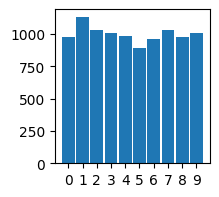

The following line contains 10 sampels of **"test"**:

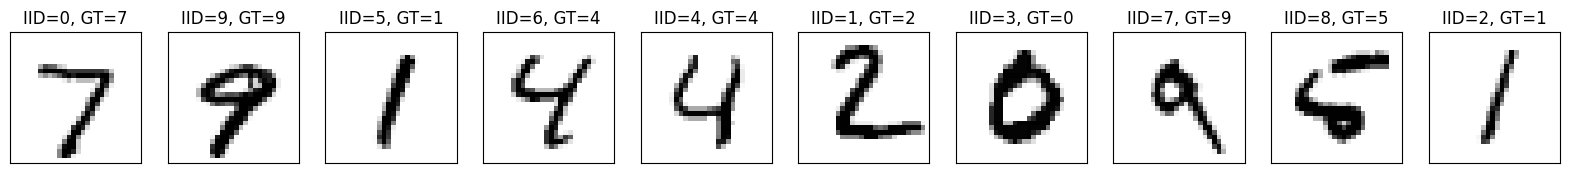

In [7]:
show_data('test', X_t, y_t)

# Train a simple classifier on the labelled training data 

Below, we will train a simple classifier, on our data. 
To visualise the history, we first define a little helper function:

In [8]:
def plotHistories(history= None, figsize=(20,7), ylim=None, **hists):
    if history:
        plt.figure(figsize=figsize)
        for hk in history.history:
            plt.plot(history.history[hk], ls='-' if hk.startswith('val') else ':', label=hk)
        plt.legend()
        plt.grid()

    else: # i.e., there are multiple histories given
        f, axs = plt.subplots(1, len(hists), figsize=figsize, sharex=True, sharey=True)
        for i,(k,hist) in enumerate(hists.items()): 
            ax = axs[i]
            for hk in hist.history:
                ax.plot(hist.history[hk], label=hk)
            ax.set_title(k)
            ax.legend()
            ax.grid()

        if ylim is not None:
               axs[0].set_ylim(ylim)

    plt.tight_layout()
    plt.show()



To ensure that all networks share a common structure, we use the following functions to create the convolutional and the dense sub-networks:

In [9]:
conv_filters_1 = 8
conv_kernel_size_1 = 3
conv_pooling_size_1 = 2
conv_filters_2 = 8
conv_kernel_size_2 = 3
conv_pooling_size_2 = 2

def create_conv_subnetwork(name_prefix, input_shape):
    i = Input(shape=input_shape, name=name_prefix+'_input')
    l = Conv2D(conv_filters_1, conv_kernel_size_1, activation='relu', name=name_prefix+'_c1', padding='same')(i)
    l = BatchNormalization(name=name_prefix+'_bn1')(l)
    l = MaxPooling2D(pool_size=conv_pooling_size_1, name=name_prefix+'_mp1')(l)
    l = Conv2D(conv_filters_2, conv_kernel_size_2, activation='relu', name=name_prefix+'_c2', padding='same')(l)
    l = BatchNormalization(name=name_prefix+'_bn2')(l)
    l = MaxPooling2D(pool_size=conv_pooling_size_2, name=name_prefix+'_mp2')(l)
    return i, l


hidden_dimension = 100

def create_dense_subnetwork(name_prefix, input_layer):
    l = Flatten(name=name_prefix+'_flatten')(input_layer)
    l = Dense(hidden_dimension, activation='relu', name=name_prefix+'_hidden')(l)
    l = Dense(num_classes, activation='softmax', name=name_prefix+'_output')(l)
    return l



In [10]:
optimizer = 'adam'

cl_inp, cl_conv  = create_conv_subnetwork('c', input_shape)
cl_out   = create_dense_subnetwork('c', cl_conv)

sc = Model(cl_inp, cl_out, name='SimpleClassifier') 
sc.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
sc.summary()


Model: "SimpleClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c_input (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 c_c1 (Conv2D)               (None, 28, 28, 8)         80        
                                                                 
 c_bn1 (BatchNormalization)  (None, 28, 28, 8)         32        
                                                                 
 c_mp1 (MaxPooling2D)        (None, 14, 14, 8)         0         
                                                                 
 c_c2 (Conv2D)               (None, 14, 14, 8)         584       
                                                                 
 c_bn2 (BatchNormalization)  (None, 14, 14, 8)         32        
                                                                 
 c_mp2 (MaxPooling2D)        (None, 7, 7, 8)      

Epoch 1/25


2023-06-22 16:41:30.617458: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 - 1s - loss: 2.5204 - acc: 0.1663 - val_loss: 2.2407 - val_acc: 0.1823 - 1s/epoch - 368ms/step
Epoch 2/25
3/3 - 1s - loss: 1.7766 - acc: 0.4217 - val_loss: 2.1749 - val_acc: 0.3799 - 683ms/epoch - 228ms/step
Epoch 3/25
3/3 - 1s - loss: 1.3075 - acc: 0.5960 - val_loss: 2.1016 - val_acc: 0.4629 - 730ms/epoch - 243ms/step
Epoch 4/25
3/3 - 1s - loss: 0.9838 - acc: 0.7057 - val_loss: 2.0269 - val_acc: 0.5093 - 675ms/epoch - 225ms/step
Epoch 5/25
3/3 - 1s - loss: 0.7643 - acc: 0.7743 - val_loss: 1.9502 - val_acc: 0.5749 - 664ms/epoch - 221ms/step
Epoch 6/25
3/3 - 1s - loss: 0.6129 - acc: 0.8283 - val_loss: 1.8765 - val_acc: 0.6188 - 639ms/epoch - 213ms/step
Epoch 7/25
3/3 - 1s - loss: 0.5040 - acc: 0.8590 - val_loss: 1.8166 - val_acc: 0.6242 - 571ms/epoch - 190ms/step
Epoch 8/25
3/3 - 1s - loss: 0.4262 - acc: 0.8800 - val_loss: 1.7650 - val_acc: 0.6377 - 636ms/epoch - 212ms/step
Epoch 9/25
3/3 - 1s - loss: 0.3685 - acc: 0.8953 - val_loss: 1.7215 - val_acc: 0.6488 - 582ms/epoch - 194ms/st

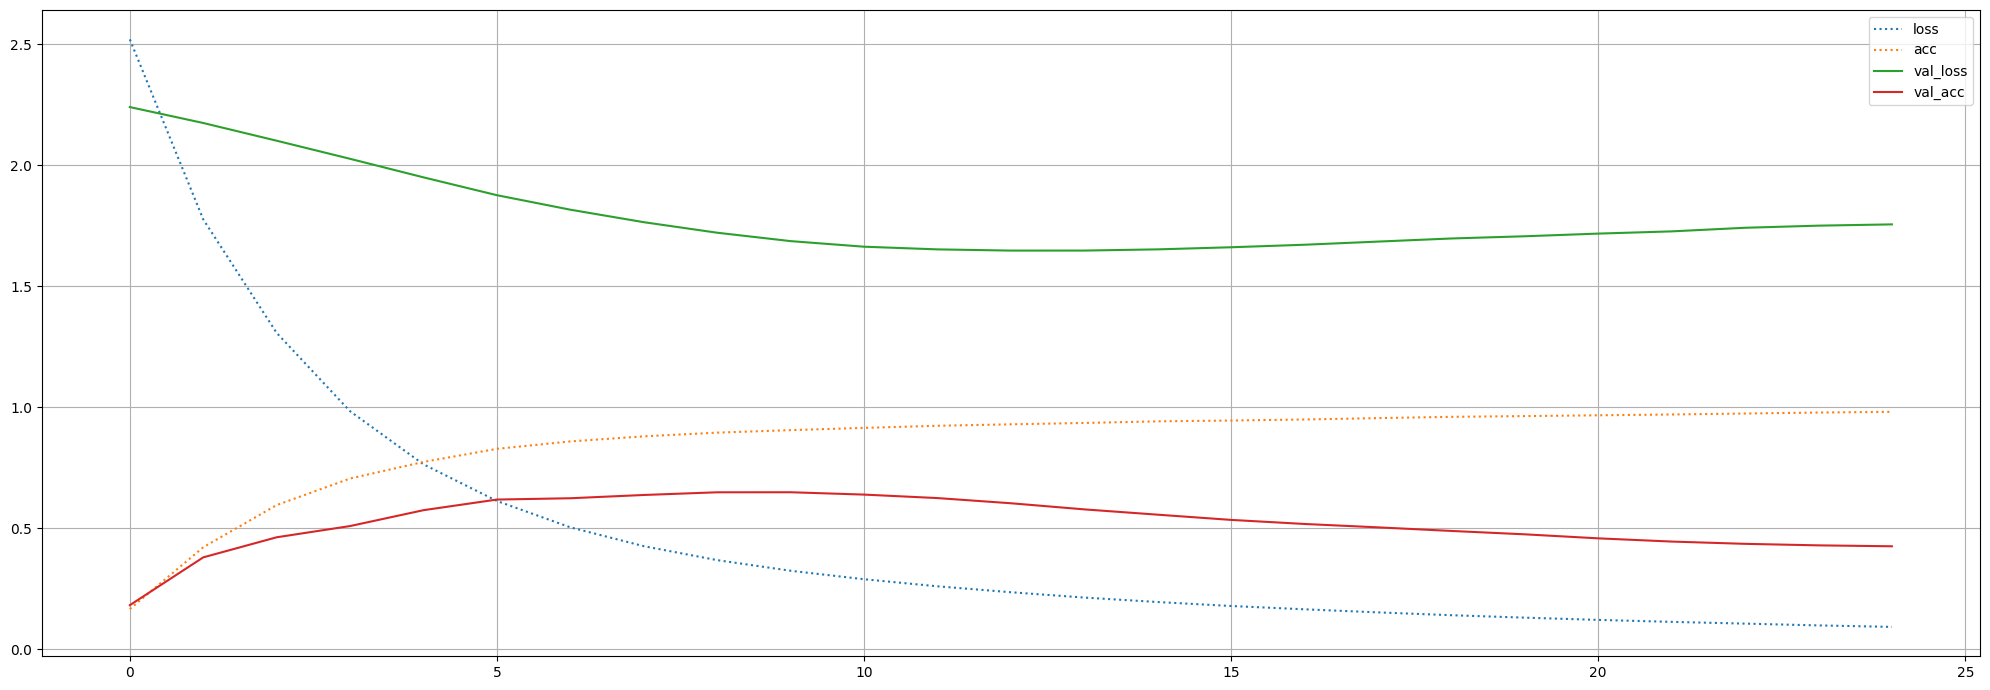

In [11]:
# just to make sure that we always use the same setting for the training
def do_fit(model, X, y, X_t, y_t):
    epochs = 25
    batch_size=1024
    hist = model.fit(X, y, validation_data=(X_t,y_t), epochs=epochs, batch_size=batch_size, verbose=2)
    plotHistories(hist)
    return hist

h_sc = do_fit(sc, X_l, y_l, X_t,y_t)


----

<font color=red>**[TASK]**</font>
Describe, after how many iterations you would stop the training process and why?

----

----

<font color=red>**[TASK]**</font>
How do you interprete the results?

----

# Training an Autoencoder on the unlabelled data
 
Please note, there is a variable `y_u` which contains the class labeles of the data contained in `X_u`, but we will **never** use it during the training. 

In [12]:

ae_inp, ae_conv  = create_conv_subnetwork('ae', input_shape)

num_layers_in_conv = len(Model(ae_inp, ae_conv).layers)
print('Created a convolutional sub-network of %i layers' % num_layers_in_conv)

l = UpSampling2D(size=conv_pooling_size_2, name='ae_up2')(ae_conv)
l = Conv2DTranspose(conv_filters_2, conv_kernel_size_2, name='ae_ct2', padding='same')(l)

l = UpSampling2D(size=conv_pooling_size_1, name='ae_up1')(l)
l = Conv2DTranspose(conv_filters_1, conv_kernel_size_1, name='ae_ct1', padding='same')(l)

ae_out   = Conv2D(input_shape[-1], kernel_size=(3, 3), activation='relu', padding='same')(l)
# instead of using the relu here, we could also use a sigmoid function to make sure all outputs are within 0..1


ae_loss = 'mse'


ae = Model(ae_inp, ae_out, name='AutoEncoder') 
ae.summary()
ae.compile(optimizer=optimizer, loss=ae_loss)




Created a convolutional sub-network of 7 layers
Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_input (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 ae_c1 (Conv2D)              (None, 28, 28, 8)         80        
                                                                 
 ae_bn1 (BatchNormalization)  (None, 28, 28, 8)        32        
                                                                 
 ae_mp1 (MaxPooling2D)       (None, 14, 14, 8)         0         
                                                                 
 ae_c2 (Conv2D)              (None, 14, 14, 8)         584       
                                                                 
 ae_bn2 (BatchNormalization)  (None, 14, 14, 8)        32        
                                                                 
 ae_mp2

Next, we train the autoencoder on the large amount of available training data. Please note that the labels are not used, but simply the input images stored in `X_u`. The autoencoder has to learn the identity mapping from `X_u` to `X_u`.

For validation we use the test images stored in `X_t` again as both input and desired output of the autoencoder.

Epoch 1/25
56/56 - 15s - loss: 0.2318 - val_loss: 0.0861 - 15s/epoch - 275ms/step
Epoch 2/25
56/56 - 15s - loss: 0.0945 - val_loss: 0.1015 - 15s/epoch - 260ms/step
Epoch 3/25
56/56 - 15s - loss: 0.0667 - val_loss: 0.1115 - 15s/epoch - 261ms/step
Epoch 4/25
56/56 - 14s - loss: 0.0461 - val_loss: 0.0740 - 14s/epoch - 250ms/step
Epoch 5/25
56/56 - 14s - loss: 0.0355 - val_loss: 0.0480 - 14s/epoch - 250ms/step
Epoch 6/25
56/56 - 14s - loss: 0.0297 - val_loss: 0.0350 - 14s/epoch - 249ms/step
Epoch 7/25
56/56 - 14s - loss: 0.0262 - val_loss: 0.0279 - 14s/epoch - 248ms/step
Epoch 8/25
56/56 - 14s - loss: 0.0238 - val_loss: 0.0236 - 14s/epoch - 253ms/step
Epoch 9/25
56/56 - 14s - loss: 0.0220 - val_loss: 0.0213 - 14s/epoch - 255ms/step
Epoch 10/25
56/56 - 15s - loss: 0.0206 - val_loss: 0.0200 - 15s/epoch - 260ms/step
Epoch 11/25
56/56 - 14s - loss: 0.0194 - val_loss: 0.0188 - 14s/epoch - 257ms/step
Epoch 12/25
56/56 - 14s - loss: 0.0185 - val_loss: 0.0180 - 14s/epoch - 249ms/step
Epoch 13/25
5

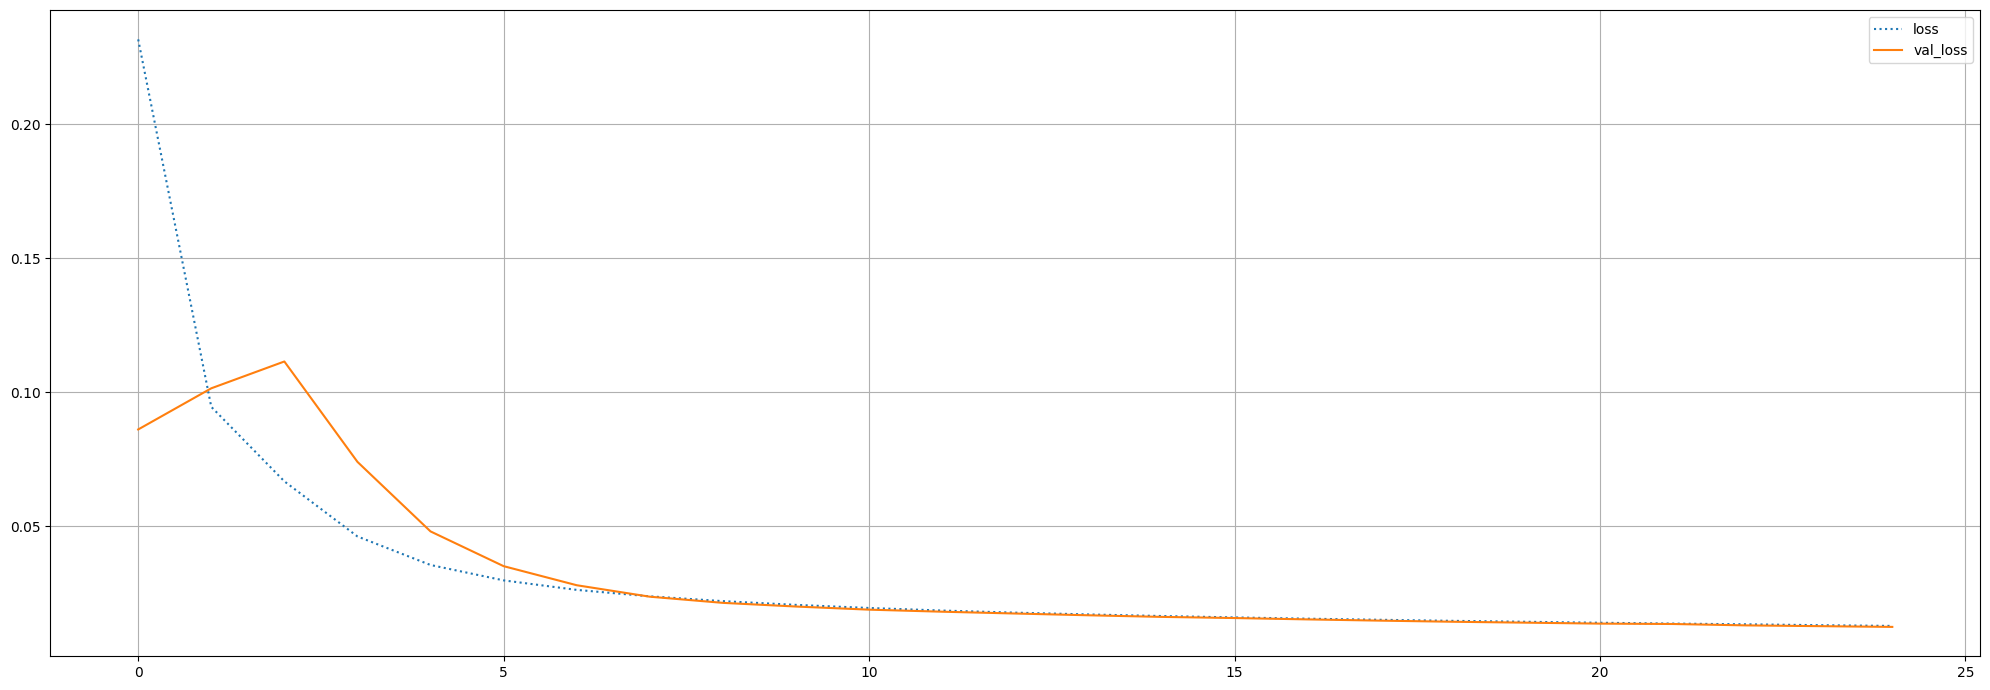

In [13]:
h_ae = do_fit(ae, X_u, X_u, X_t, X_t)

Let's look at the output of the autoencoder and compare it to the inputs

1/1 [==============================] - 0s 68ms/step


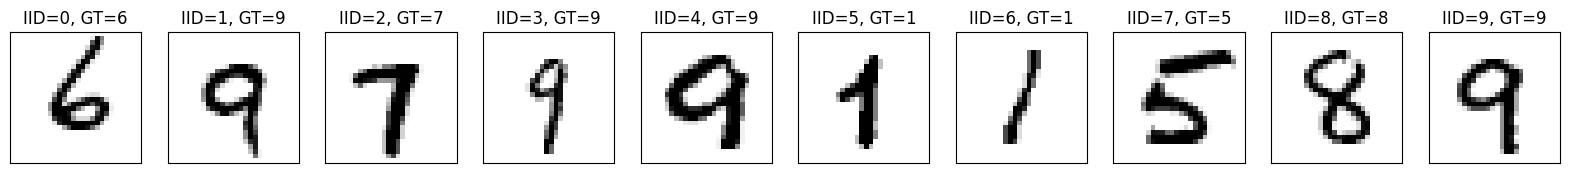

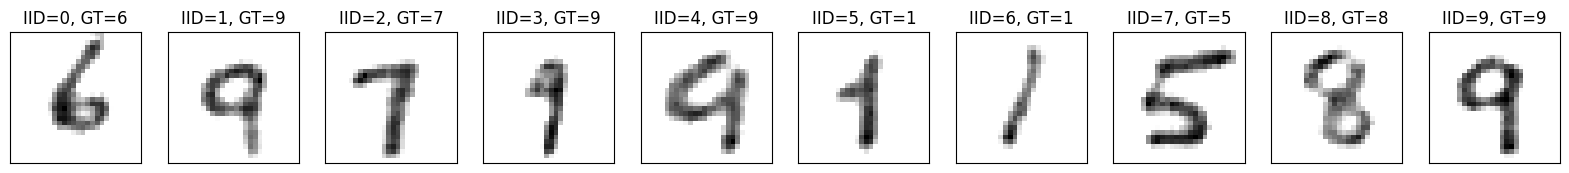

In [14]:
n_images = 10
X_u_ae = ae.predict(X_u[0:n_images])

showImages(n_images, y_u, X_u, random=False)
showImages(n_images, y_u, X_u_ae, random=False)


Now we have an autoencoder which is trained on the large amount of unlabelled data, let's check if this helps to build a better classifier.
For this, we use the encoder part of the autoencoder, and add a dense classification layer (constructed via `create_dense_subnetwork` as above. 

In [15]:
cl_ae_out   = create_dense_subnetwork('cl_ae_', ae_conv)

cl_ae = Model(ae_inp, cl_ae_out, name='AEClassifier') 

cl_ae.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
cl_ae.summary()


Model: "AEClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_input (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 ae_c1 (Conv2D)              (None, 28, 28, 8)         80        
                                                                 
 ae_bn1 (BatchNormalization)  (None, 28, 28, 8)        32        
                                                                 
 ae_mp1 (MaxPooling2D)       (None, 14, 14, 8)         0         
                                                                 
 ae_c2 (Conv2D)              (None, 14, 14, 8)         584       
                                                                 
 ae_bn2 (BatchNormalization)  (None, 14, 14, 8)        32        
                                                                 
 ae_mp2 (MaxPooling2D)       (None, 7, 7, 8)          

Both classifier models (the *“simple classifier”* constructed above and the encoder+dense network just constructed are now identical. 
As a comparison let's look at the summary of the `sc` constructed above:

In [16]:
sc.summary()

Model: "SimpleClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c_input (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 c_c1 (Conv2D)               (None, 28, 28, 8)         80        
                                                                 
 c_bn1 (BatchNormalization)  (None, 28, 28, 8)         32        
                                                                 
 c_mp1 (MaxPooling2D)        (None, 14, 14, 8)         0         
                                                                 
 c_c2 (Conv2D)               (None, 14, 14, 8)         584       
                                                                 
 c_bn2 (BatchNormalization)  (None, 14, 14, 8)         32        
                                                                 
 c_mp2 (MaxPooling2D)        (None, 7, 7, 8)      

We will now create a copy of the ae-based classifier but fix all weights which correspond to the convolutional layers.

In [17]:
# create a copy of the structure of the ae-based classifier
cl_ae_fc = clone_model(cl_ae)
cl_ae_fc._name = 'AEClassifier_FixedWeights'

# copy the weights 
for l1, l2 in zip(cl_ae.layers, cl_ae_fc.layers):
    l2.set_weights(l1.get_weights())

# freeze the weights of the convolutional sub-network by making the corresponding layers un-trainable
for l in cl_ae_fc.layers[0:num_layers_in_conv]:
    l.trainable = False

cl_ae_fc.summary()
cl_ae_fc.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])



Model: "AEClassifier_FixedWeights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_input (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 ae_c1 (Conv2D)              (None, 28, 28, 8)         80        
                                                                 
 ae_bn1 (BatchNormalization)  (None, 28, 28, 8)        32        
                                                                 
 ae_mp1 (MaxPooling2D)       (None, 14, 14, 8)         0         
                                                                 
 ae_c2 (Conv2D)              (None, 14, 14, 8)         584       
                                                                 
 ae_bn2 (BatchNormalization)  (None, 14, 14, 8)        32        
                                                                 
 ae_mp2 (MaxPooling2D)       (None, 7, 7,

Let's train the two sub-autoencoder-based networks:

Epoch 1/25
3/3 - 1s - loss: 3.0008 - acc: 0.0963 - val_loss: 2.2880 - val_acc: 0.1948 - 598ms/epoch - 199ms/step
Epoch 2/25
3/3 - 0s - loss: 1.9951 - acc: 0.2927 - val_loss: 1.5538 - val_acc: 0.4985 - 365ms/epoch - 122ms/step
Epoch 3/25
3/3 - 0s - loss: 1.4413 - acc: 0.5427 - val_loss: 1.2002 - val_acc: 0.6289 - 394ms/epoch - 131ms/step
Epoch 4/25
3/3 - 0s - loss: 1.1406 - acc: 0.6437 - val_loss: 0.9522 - val_acc: 0.7163 - 394ms/epoch - 131ms/step
Epoch 5/25
3/3 - 0s - loss: 0.8963 - acc: 0.7360 - val_loss: 0.7926 - val_acc: 0.7729 - 373ms/epoch - 124ms/step
Epoch 6/25
3/3 - 0s - loss: 0.7423 - acc: 0.7840 - val_loss: 0.6998 - val_acc: 0.7989 - 379ms/epoch - 126ms/step
Epoch 7/25
3/3 - 0s - loss: 0.6374 - acc: 0.8150 - val_loss: 0.6258 - val_acc: 0.8228 - 354ms/epoch - 118ms/step
Epoch 8/25
3/3 - 0s - loss: 0.5562 - acc: 0.8403 - val_loss: 0.5586 - val_acc: 0.8415 - 361ms/epoch - 120ms/step
Epoch 9/25
3/3 - 0s - loss: 0.4916 - acc: 0.8557 - val_loss: 0.5175 - val_acc: 0.8517 - 371ms/ep

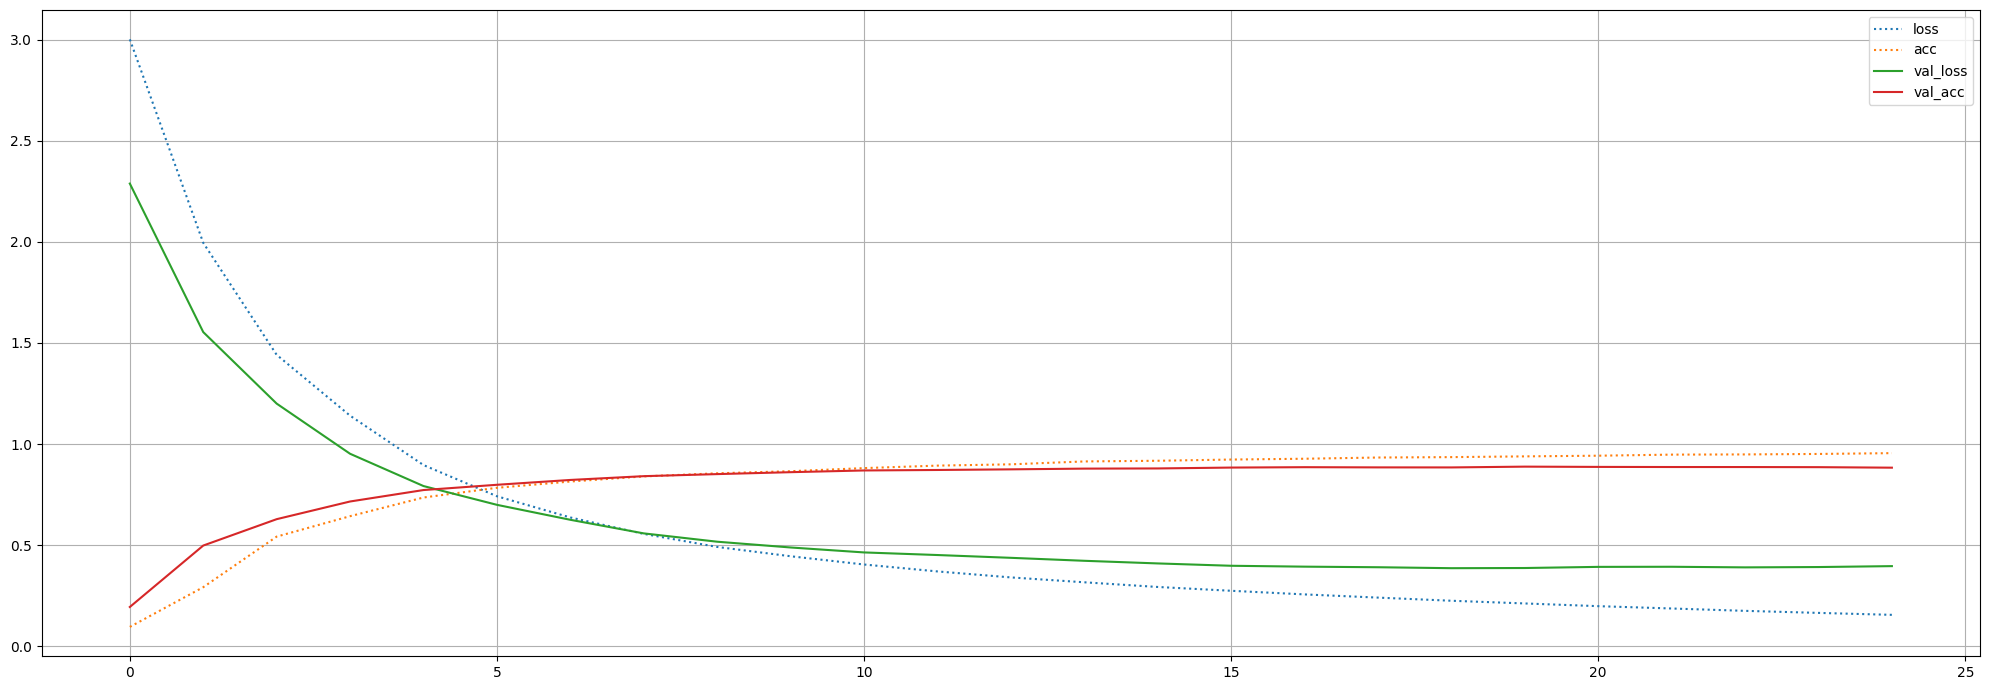

In [18]:
h_cl_ae = do_fit(cl_ae, X_l, y_l, X_t,y_t)

Epoch 1/25
3/3 - 1s - loss: 3.0553 - acc: 0.0973 - val_loss: 2.3405 - val_acc: 0.1814 - 584ms/epoch - 195ms/step
Epoch 2/25
3/3 - 0s - loss: 2.0501 - acc: 0.2703 - val_loss: 1.6279 - val_acc: 0.4670 - 264ms/epoch - 88ms/step
Epoch 3/25
3/3 - 0s - loss: 1.4858 - acc: 0.5207 - val_loss: 1.2682 - val_acc: 0.5998 - 254ms/epoch - 85ms/step
Epoch 4/25
3/3 - 0s - loss: 1.1770 - acc: 0.6260 - val_loss: 0.9933 - val_acc: 0.7052 - 241ms/epoch - 80ms/step
Epoch 5/25
3/3 - 0s - loss: 0.9217 - acc: 0.7317 - val_loss: 0.8077 - val_acc: 0.7724 - 251ms/epoch - 84ms/step
Epoch 6/25
3/3 - 0s - loss: 0.7610 - acc: 0.7853 - val_loss: 0.6983 - val_acc: 0.8012 - 257ms/epoch - 86ms/step
Epoch 7/25
3/3 - 0s - loss: 0.6572 - acc: 0.8147 - val_loss: 0.6143 - val_acc: 0.8238 - 261ms/epoch - 87ms/step
Epoch 8/25
3/3 - 0s - loss: 0.5761 - acc: 0.8343 - val_loss: 0.5473 - val_acc: 0.8417 - 254ms/epoch - 85ms/step
Epoch 9/25
3/3 - 0s - loss: 0.5114 - acc: 0.8510 - val_loss: 0.5043 - val_acc: 0.8506 - 277ms/epoch - 9

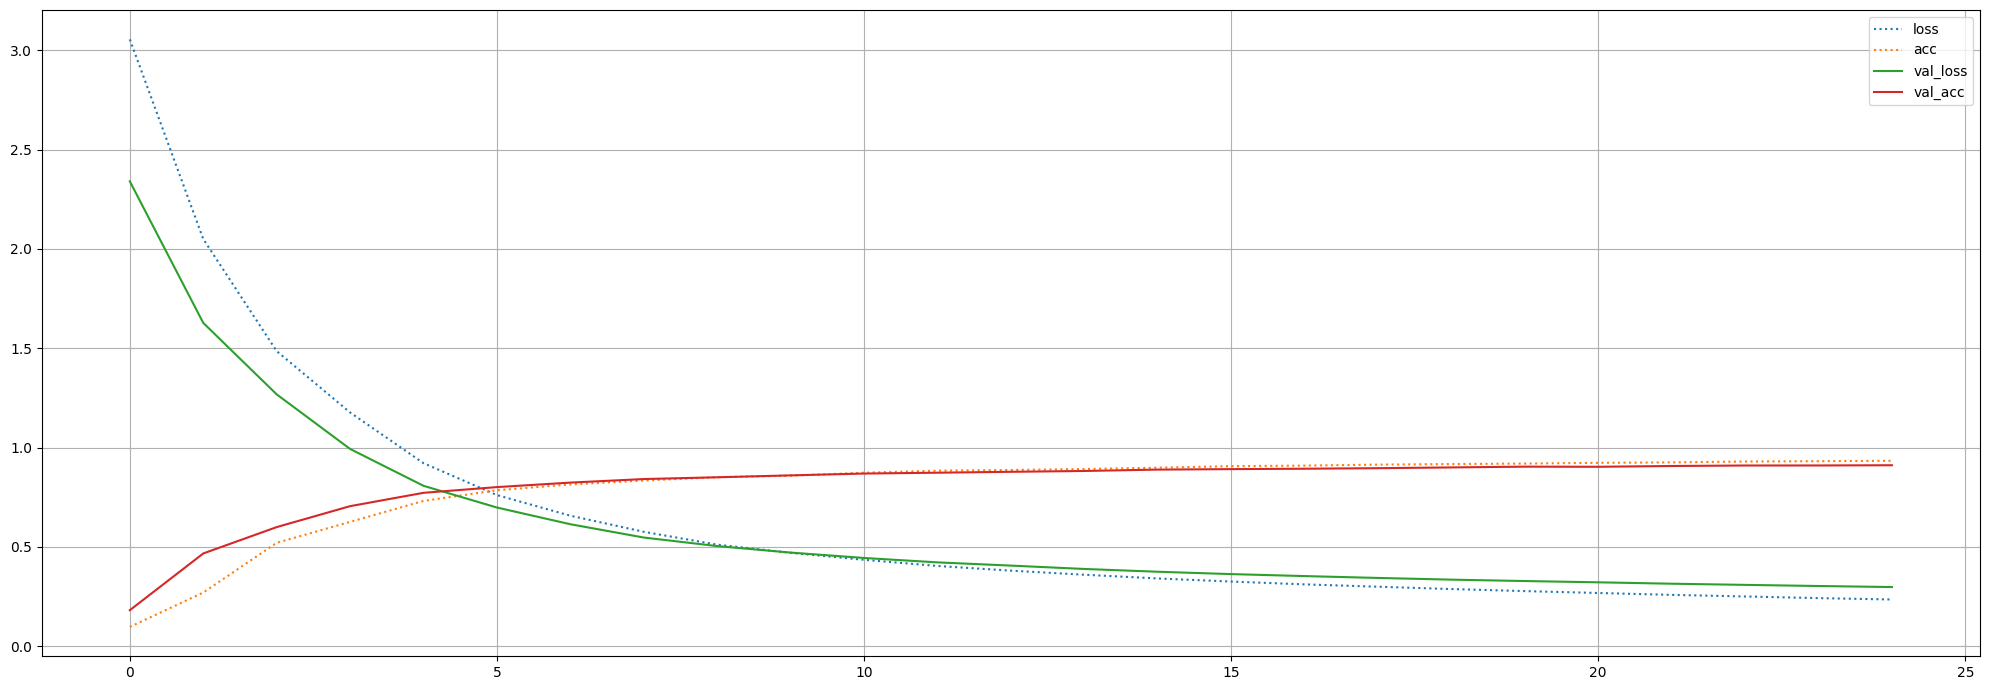

In [19]:
h_cl_ae_fc = do_fit(cl_ae_fc, X_l, y_l, X_t,y_t)


In [20]:
sc.evaluate(X_t, y_t)

313/313 [==============================] - 1s 4ms/step - loss: 1.7559 - acc: 0.4257


[1.7559123039245605, 0.42570000886917114]

In [21]:
cl_ae.evaluate(X_t, y_t)

313/313 [==============================] - 1s 2ms/step - loss: 0.3968 - acc: 0.8835


[0.39677754044532776, 0.8834999799728394]

In [22]:
cl_ae_fc.evaluate(X_t, y_t)

313/313 [==============================] - 1s 2ms/step - loss: 0.2980 - acc: 0.9112


[0.29798293113708496, 0.9111999869346619]

**[TODO]** Describe the differences between the three classifiers' performances. 

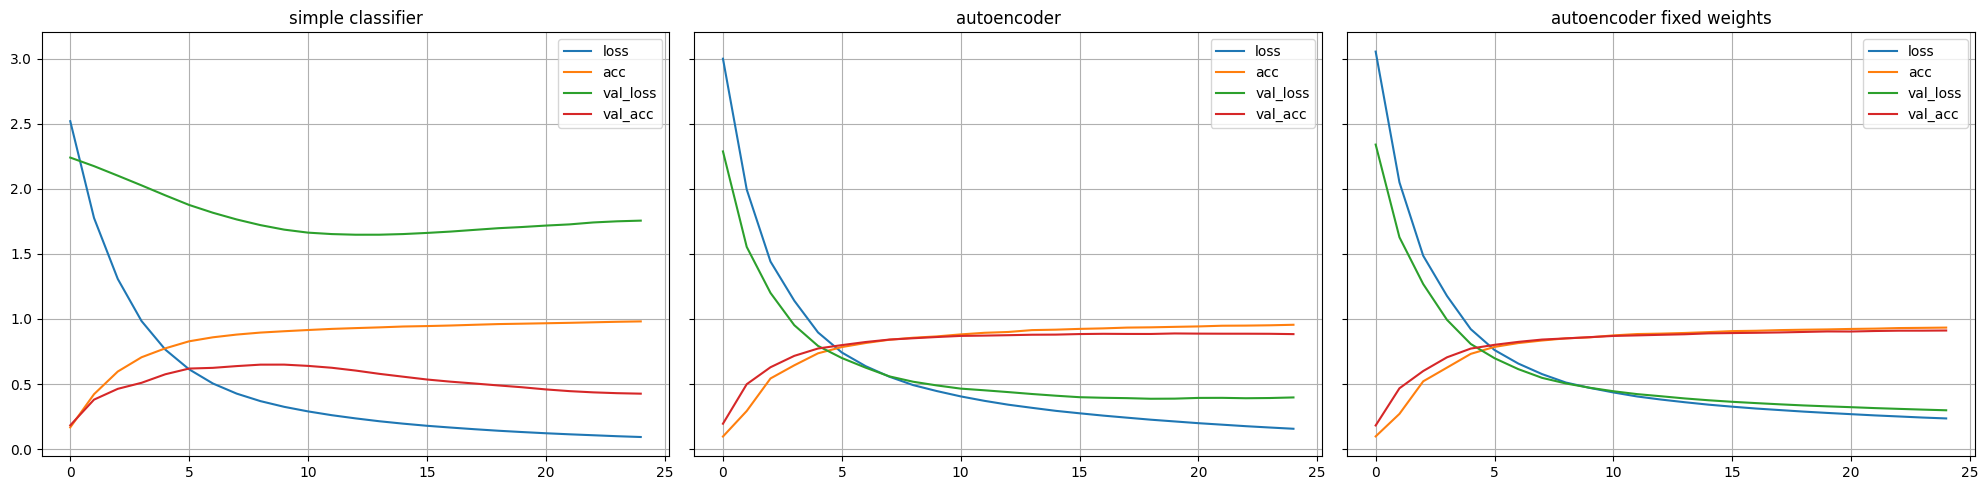

In [23]:
plotHistories(figsize=(20,5), **{
    'simple classifier': h_sc, 
    'autoencoder': h_cl_ae,
    'autoencoder fixed weights': h_cl_ae_fc
})

So far the kernels of the fixed-weight encoder-subnetwork are not modified by the training because we made them un-trainable. Now we will make them trainable as well and continue the training

In [24]:
for l in cl_ae_fc.layers:
    l.trainable = True
cl_ae_fc.summary()


Model: "AEClassifier_FixedWeights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_input (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 ae_c1 (Conv2D)              (None, 28, 28, 8)         80        
                                                                 
 ae_bn1 (BatchNormalization)  (None, 28, 28, 8)        32        
                                                                 
 ae_mp1 (MaxPooling2D)       (None, 14, 14, 8)         0         
                                                                 
 ae_c2 (Conv2D)              (None, 14, 14, 8)         584       
                                                                 
 ae_bn2 (BatchNormalization)  (None, 14, 14, 8)        32        
                                                                 
 ae_mp2 (MaxPooling2D)       (None, 7, 7,

Epoch 1/25
3/3 - 0s - loss: 0.2281 - acc: 0.9367 - val_loss: 0.2929 - val_acc: 0.9132 - 199ms/epoch - 66ms/step
Epoch 2/25
3/3 - 0s - loss: 0.2213 - acc: 0.9383 - val_loss: 0.2890 - val_acc: 0.9146 - 183ms/epoch - 61ms/step
Epoch 3/25
3/3 - 0s - loss: 0.2151 - acc: 0.9390 - val_loss: 0.2857 - val_acc: 0.9149 - 166ms/epoch - 55ms/step
Epoch 4/25
3/3 - 0s - loss: 0.2094 - acc: 0.9397 - val_loss: 0.2816 - val_acc: 0.9155 - 184ms/epoch - 61ms/step
Epoch 5/25
3/3 - 0s - loss: 0.2033 - acc: 0.9417 - val_loss: 0.2771 - val_acc: 0.9174 - 190ms/epoch - 63ms/step
Epoch 6/25
3/3 - 0s - loss: 0.1981 - acc: 0.9440 - val_loss: 0.2729 - val_acc: 0.9183 - 180ms/epoch - 60ms/step
Epoch 7/25
3/3 - 0s - loss: 0.1923 - acc: 0.9470 - val_loss: 0.2696 - val_acc: 0.9193 - 181ms/epoch - 60ms/step
Epoch 8/25
3/3 - 0s - loss: 0.1878 - acc: 0.9470 - val_loss: 0.2664 - val_acc: 0.9200 - 181ms/epoch - 60ms/step
Epoch 9/25
3/3 - 0s - loss: 0.1829 - acc: 0.9487 - val_loss: 0.2641 - val_acc: 0.9199 - 184ms/epoch - 61

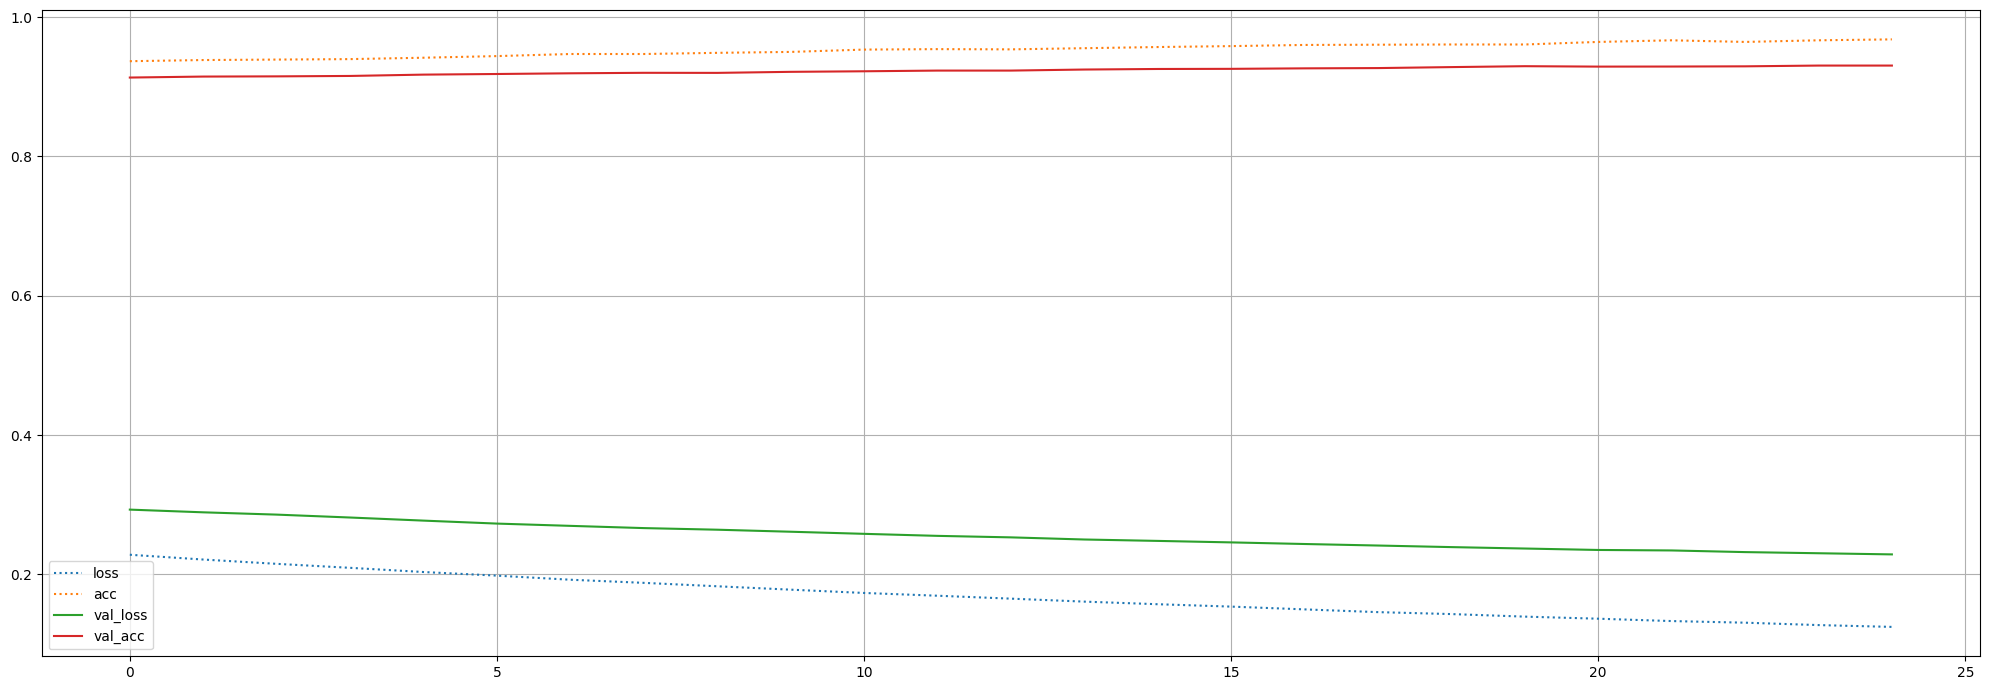

In [25]:
h_cl_ae_fc_2 = do_fit(cl_ae_fc, X_l, y_l, X_t, y_t)


To make the comparison fair, we will also train the simple classifier again. 

Epoch 1/25
3/3 - 0s - loss: 0.1465 - acc: 0.9573 - val_loss: 0.3953 - val_acc: 0.8836 - 273ms/epoch - 91ms/step
Epoch 2/25
3/3 - 0s - loss: 0.1380 - acc: 0.9607 - val_loss: 0.3992 - val_acc: 0.8807 - 253ms/epoch - 84ms/step
Epoch 3/25
3/3 - 0s - loss: 0.1303 - acc: 0.9650 - val_loss: 0.4061 - val_acc: 0.8762 - 253ms/epoch - 84ms/step
Epoch 4/25
3/3 - 0s - loss: 0.1227 - acc: 0.9660 - val_loss: 0.4083 - val_acc: 0.8740 - 253ms/epoch - 84ms/step
Epoch 5/25
3/3 - 0s - loss: 0.1161 - acc: 0.9670 - val_loss: 0.4110 - val_acc: 0.8704 - 258ms/epoch - 86ms/step
Epoch 6/25
3/3 - 0s - loss: 0.1097 - acc: 0.9710 - val_loss: 0.4089 - val_acc: 0.8703 - 247ms/epoch - 82ms/step
Epoch 7/25
3/3 - 0s - loss: 0.1039 - acc: 0.9733 - val_loss: 0.4108 - val_acc: 0.8683 - 251ms/epoch - 84ms/step
Epoch 8/25
3/3 - 0s - loss: 0.0983 - acc: 0.9760 - val_loss: 0.4118 - val_acc: 0.8671 - 253ms/epoch - 84ms/step
Epoch 9/25
3/3 - 0s - loss: 0.0930 - acc: 0.9777 - val_loss: 0.4104 - val_acc: 0.8663 - 257ms/epoch - 86

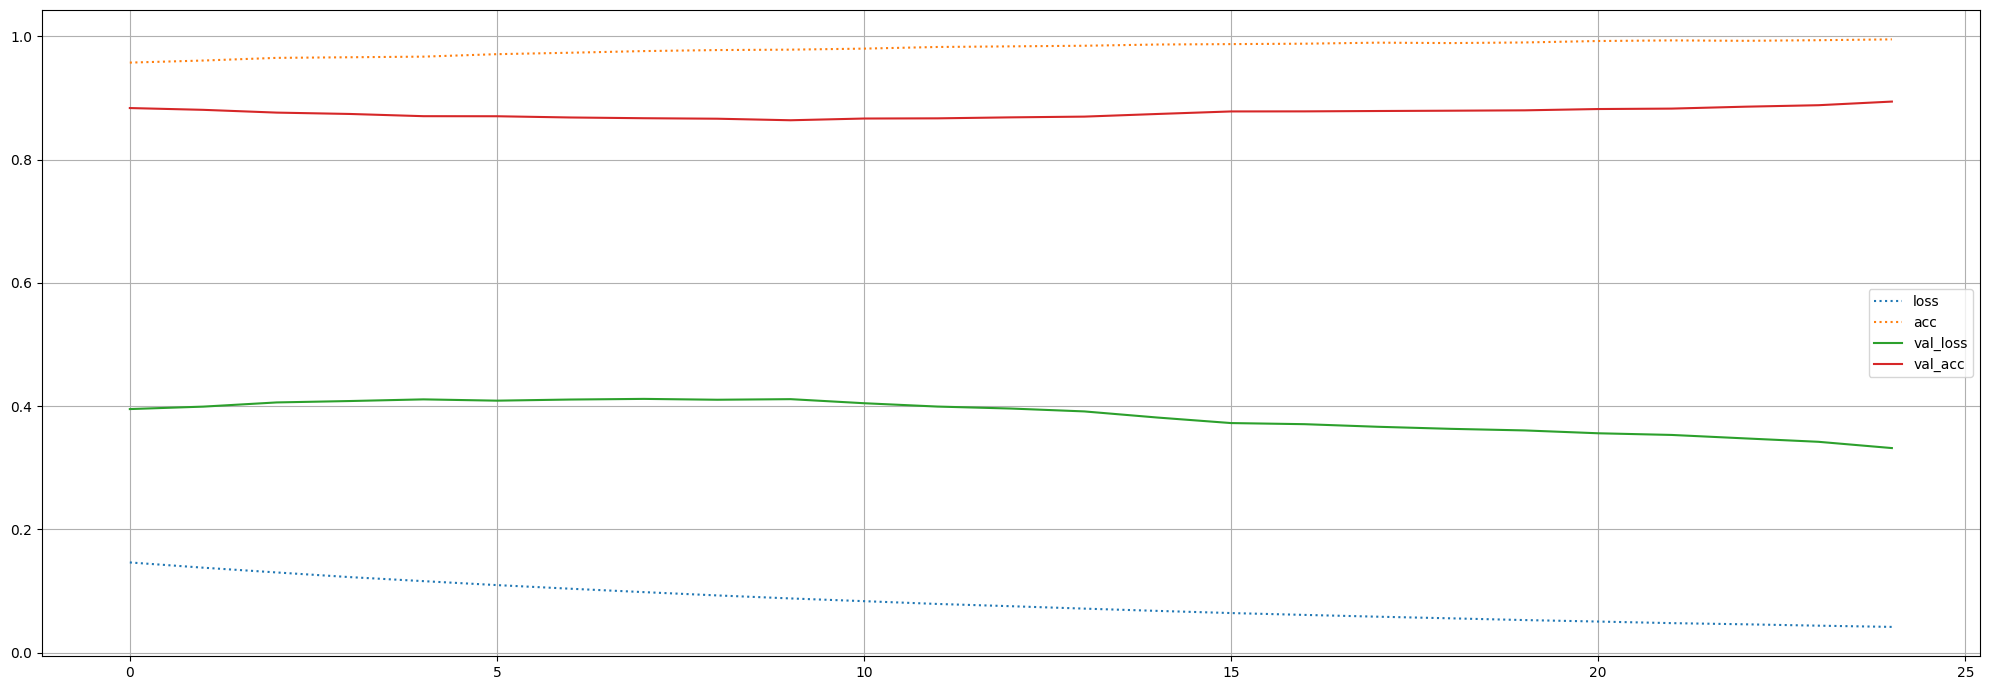

In [26]:
h_cl_ae_2 = do_fit(cl_ae, X_l, y_l, X_t,y_t)



Epoch 1/25
3/3 - 0s - loss: 0.0867 - acc: 0.9823 - val_loss: 1.7599 - val_acc: 0.4173 - 286ms/epoch - 95ms/step
Epoch 2/25
3/3 - 0s - loss: 0.0813 - acc: 0.9857 - val_loss: 1.7663 - val_acc: 0.4113 - 242ms/epoch - 81ms/step
Epoch 3/25
3/3 - 0s - loss: 0.0764 - acc: 0.9873 - val_loss: 1.7745 - val_acc: 0.4034 - 231ms/epoch - 77ms/step
Epoch 4/25
3/3 - 0s - loss: 0.0717 - acc: 0.9890 - val_loss: 1.7836 - val_acc: 0.3964 - 243ms/epoch - 81ms/step
Epoch 5/25
3/3 - 0s - loss: 0.0674 - acc: 0.9920 - val_loss: 1.7912 - val_acc: 0.3903 - 254ms/epoch - 85ms/step
Epoch 6/25
3/3 - 0s - loss: 0.0633 - acc: 0.9920 - val_loss: 1.7919 - val_acc: 0.3888 - 250ms/epoch - 83ms/step
Epoch 7/25
3/3 - 0s - loss: 0.0597 - acc: 0.9930 - val_loss: 1.7919 - val_acc: 0.3858 - 249ms/epoch - 83ms/step
Epoch 8/25
3/3 - 0s - loss: 0.0563 - acc: 0.9930 - val_loss: 1.8009 - val_acc: 0.3796 - 240ms/epoch - 80ms/step
Epoch 9/25
3/3 - 0s - loss: 0.0532 - acc: 0.9937 - val_loss: 1.8068 - val_acc: 0.3759 - 240ms/epoch - 80

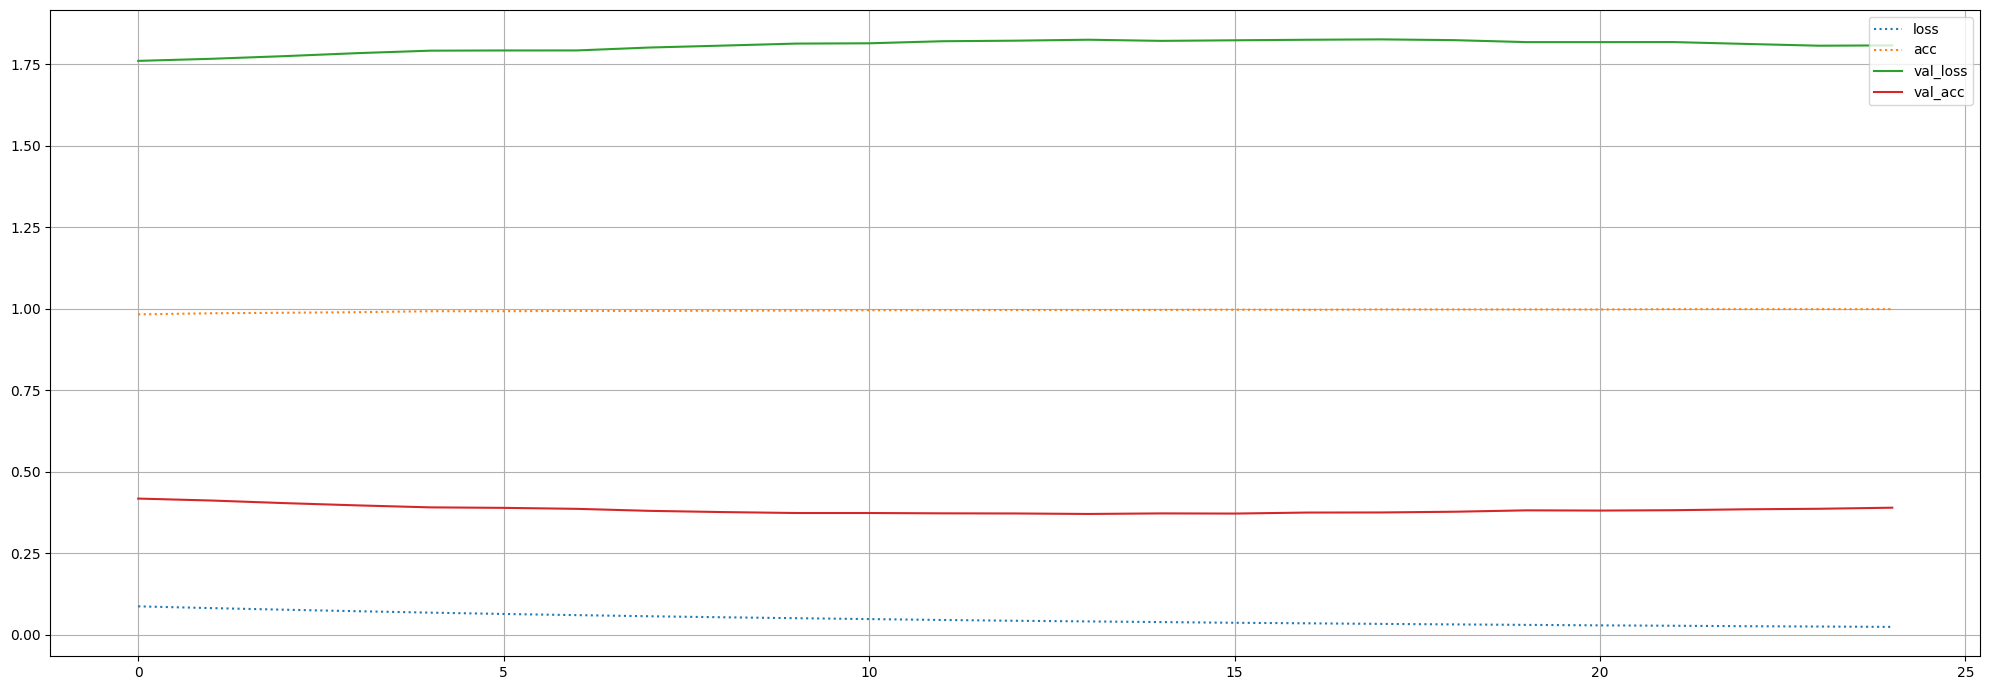

In [27]:
h_sc_2 = do_fit(sc, X_l, y_l, X_t,y_t)


Now let's evaluate the ae-based classifier again after we continued the training also in the convolutional layer 

In [28]:
cl_ae_fc.evaluate(X_t, y_t)
cl_ae.evaluate(X_t, y_t)

313/313 [==============================] - 1s 2ms/step - loss: 0.3320 - acc: 0.8941


[0.33201363682746887, 0.89410001039505]

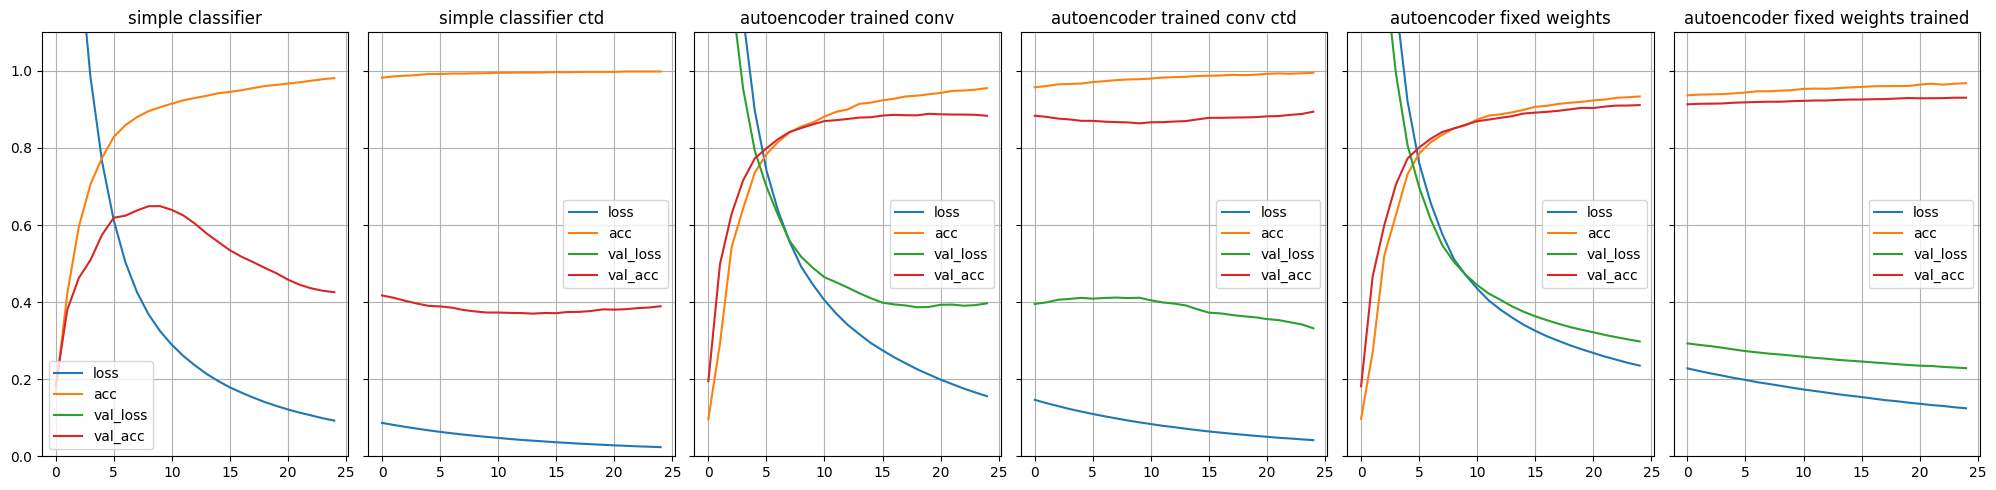

In [29]:
plotHistories(figsize=(20,5), ylim=(0,1.1), **{
    'simple classifier': h_sc, 
    'simple classifier ctd': h_sc_2, 
    'autoencoder trained conv': h_cl_ae, 
    'autoencoder trained conv ctd': h_cl_ae_2, 
    'autoencoder fixed weights': h_cl_ae_fc, 
    'autoencoder fixed weights trained': h_cl_ae_fc_2, 
})


Now let's have a closer look at the accuracies on training and test set in a direct comparison between the models

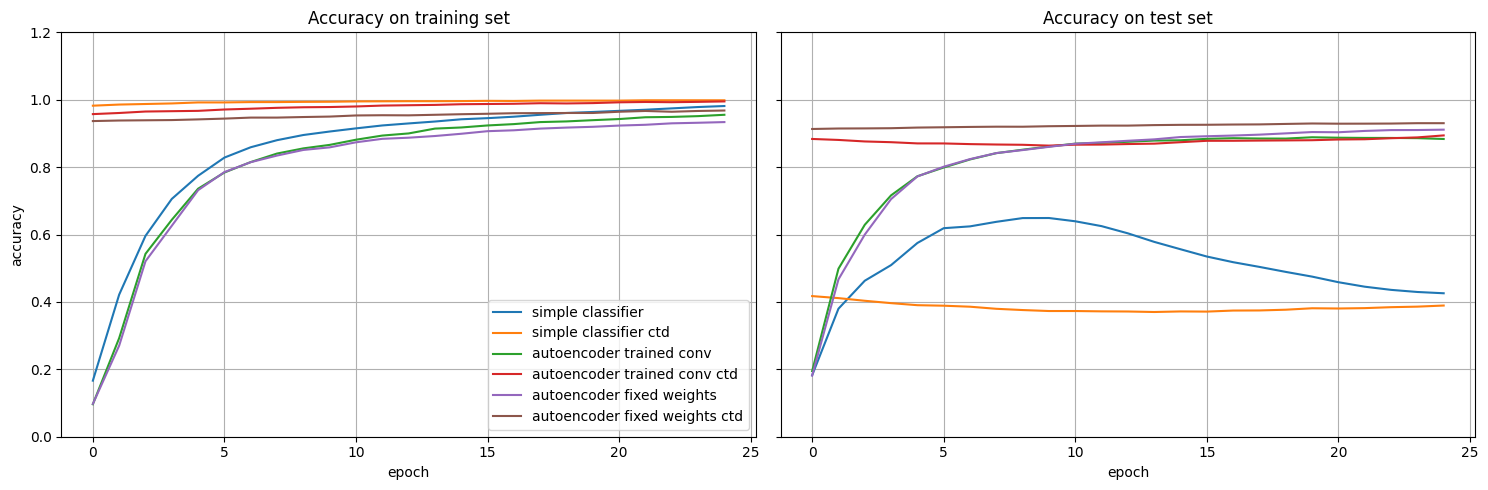

In [30]:
f, [ax0,ax1] = plt.subplots(1,2,sharey=True, figsize=(15,5))

ax0.set_title('Accuracy on training set')
ax1.set_title('Accuracy on test set')

for l,h in {
        'simple classifier': h_sc, 
        'simple classifier ctd': h_sc_2, 
        'autoencoder trained conv': h_cl_ae,
        'autoencoder trained conv ctd': h_cl_ae_2,
        'autoencoder fixed weights': h_cl_ae_fc, 
        'autoencoder fixed weights ctd': h_cl_ae_fc_2
    }.items():
        ax0.plot(h.history['acc'], label=l)
        ax1.plot(h.history['val_acc'], label=l)

ax0.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax1.set_xlabel('epoch')

ax0.legend()
#ax1.legend()
ax0.set_ylim(0,1.2)
ax0.grid()
ax1.grid()
plt.tight_layout()

plt.show()

----

<font color=red>**[TASK]**</font>
Please create two copies of this notebook change the cell which loads the dataset from `cifar10` to `mnist` and `fashion_mnist` respectively.
Re-run the whole notebook for the other two datasets as well.
Compare the results and explain the differences.

----

